In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
    FluxPointsEstimator,
    FluxPointsDataset,
    ReflectedRegionsBackgroundMaker,
    plot_spectrum_datasets_off_regions,
)
from gammapy.modeling import Fit, Parameter, Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis
from itertools import combinations

In [3]:
import scipy.stats as stats
import math
import statistics

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [6]:
livetime = 8 * u.h
n_obs = 125
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 40), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 200), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [7]:
# Define spectral model - a simple Power Law in this case
model_simu = PowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True


In [8]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 28800.0 s



In [9]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [10]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 3498 
    Total predicted counts          : nan
    Total background counts         : 3534.26

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.88e+04 s

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [11]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 6276 
    Total predicted counts          : 6305.83
    Total off counts                : 17576.00

    Total background counts         : 3515.20

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 8.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 60.58

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [12]:
%%time

datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 736 ms, sys: 12.4 ms, total: 748 ms
Wall time: 749 ms


Text(0, 0.5, 'No. of observations')

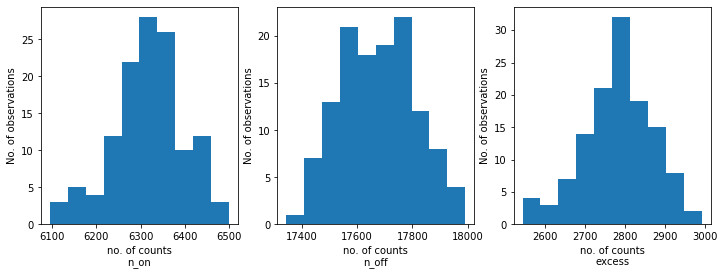

In [13]:
n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:
%%time
results = []
fpes = []
e_edges = np.logspace(-1.5, 2.0, 10) * u.TeV
model_best_joints = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.run()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "reference":result.parameters["reference"].value,
        }
    )
    print(result.parameters.to_table())
    fpe = FluxPointsEstimator(datasets=[dataset], e_edges=e_edges)
    flux_points = fpe.run()
    print(flux_points.table_formatted)
    fpes.append(flux_points)
    model_best_joint = model.copy()
    model_best_joint.spectral_model.parameters.covariance = (result.parameters.covariance)
    model_best_joints.append(model_best_joint)

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.252e+00 1.640e-02                nan nan  False
amplitude 1.262e-12 3.431e-14 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.123e-10       1.129e-10       1.116e-10
 0.121  0.072   0.203 ...       7.402e-12       7.443e-12       7.362e-12
 0.307  0.203   0.464 ...       9.776e-13       9.884e-13       9.668e-13
 0.702  0.464   1.061 ...       1.791e-13       1.824e-13       1.759e-13
 1.778  1.061   2.981 ...       2.135e-14       2.174e-14       2.096e-14
 4.507  2.981   6.813 ...       3.655e-15       3.759e-15       3.553e-15
10.300  6.813  15.571 ...       8.

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.091e-10       1.097e-10       1.084e-10
 0.121  0.072   0.203 ...       7.317e-12       7.360e-12       7.274e-12
 0.307  0.203   0.464 ...       1.004e-12       1.011e-12       9.972e-13
 0.702  0.464   1.061 ...       1.716e-13       1.745e-13       1.687e-13
 1.778  1.061   2.981 ...       2.182e-14       2.229e-14       2.136e-14
 4.507  2.981   6.813 ...       3.600e-15       3.715e-15       3.488e-15
10.300  6.813  15.571 ...       8.624e-16       8.991e-16       8.264e-16
26.102 15.571  43.755 ...       1.635e-16       1.724e-16       1.548e-16
66.147 43.755 100.000 ...       4.448e-17       4.906e-17       4.012e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.115e-10       1.121e-10       1.109e-10
 0.121  0.072   0.203 ...       7.438e-12       7.468e-12       7.408e-12
 0.307  0.203   0.464 ...       1.016e-12       1.025e-12       1.006e-12
 0.702  0.464   1.061 ...       1.806e-13       1.835e-13       1.778e-13
 1.778  1.061   2.981 ...       2.109e-14       2.148e-14       2.070e-14
 4.507  2.981   6.813 ...       3.506e-15       3.604e-15       3.411e-15
10.300  6.813  15.571 ...       8.007e-16       8.372e-16       7.649e-16
26.102 15.571  43.755 ...       1.404e-16       1.492e-16       1.318e-16
66.147 43.755 100.000 ...       3.271e-17       3.728e-17       2.843e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.092e-10       1.095e-10       1.090e-10
 0.121  0.072   0.203 ...       7.339e-12       7.389e-12       7.290e-12
 0.307  0.203   0.464 ...       9.918e-13       1.002e-12       9.812e-13
 0.702  0.464   1.061 ...       1.794e-13       1.823e-13       1.766e-13
 1.778  1.061   2.981 ...       2.243e-14       2.286e-14       2.201e-14
 4.507  2.981   6.813 ...       3.630e-15       3.722e-15       3.538e-15
10.300  6.813  15.571 ...       9.834e-16       1.021e-15       9.464e-16
26.102 15.571  43.755 ...       1.699e-16       1.788e-16       1.612e-16
66.147 43.755 100.000 ...       3.553e-17       4.014e-17       3.120e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.090e-10       1.096e-10       1.083e-10
 0.121  0.072   0.203 ...       7.305e-12       7.354e-12       7.257e-12
 0.307  0.203   0.464 ...       9.993e-13       1.010e-12       9.888e-13
 0.702  0.464   1.061 ...       1.799e-13       1.828e-13       1.770e-13
 1.778  1.061   2.981 ...       2.306e-14       2.346e-14       2.267e-14
 4.507  2.981   6.813 ...       3.696e-15       3.789e-15       3.605e-15
10.300  6.813  15.571 ...       1.058e-15       1.098e-15       1.020e-15
26.102 15.571  43.755 ...       1.509e-16       1.598e-16       1.423e-16
66.147 43.755 100.000 ...       3.804e-17       4.266e-17       3.370e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.106e-10       1.108e-10       1.103e-10
 0.121  0.072   0.203 ...       7.438e-12       7.478e-12       7.397e-12
 0.307  0.203   0.464 ...       9.968e-13       1.000e-12       9.930e-13
 0.702  0.464   1.061 ...       1.850e-13       1.881e-13       1.820e-13
 1.778  1.061   2.981 ...       2.137e-14       2.188e-14       2.088e-14
 4.507  2.981   6.813 ...       3.676e-15       3.773e-15       3.582e-15
10.300  6.813  15.571 ...       8.879e-16       9.278e-16       8.493e-16
26.102 15.571  43.755 ...       1.611e-16       1.700e-16       1.524e-16
66.147 43.755 100.000 ...       3.786e-17       4.253e-17       3.349e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.099e-10       1.106e-10       1.092e-10
 0.121  0.072   0.203 ...       7.320e-12       7.369e-12       7.271e-12
 0.307  0.203   0.464 ...       1.002e-12       1.012e-12       9.911e-13
 0.702  0.464   1.061 ...       1.728e-13       1.756e-13       1.700e-13
 1.778  1.061   2.981 ...       2.104e-14       2.145e-14       2.064e-14
 4.507  2.981   6.813 ...       3.503e-15       3.614e-15       3.396e-15
10.300  6.813  15.571 ...       9.031e-16       9.438e-16       8.637e-16
26.102 15.571  43.755 ...       1.479e-16       1.569e-16       1.393e-16
66.147 43.755 100.000 ...       4.828e-17       5.285e-17       4.391e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.091e-10       1.097e-10       1.085e-10
 0.121  0.072   0.203 ...       7.499e-12       7.552e-12       7.447e-12
 0.307  0.203   0.464 ...       1.020e-12       1.026e-12       1.014e-12
 0.702  0.464   1.061 ...       1.757e-13       1.786e-13       1.729e-13
 1.778  1.061   2.981 ...       2.149e-14       2.201e-14       2.098e-14
 4.507  2.981   6.813 ...       3.579e-15       3.672e-15       3.486e-15
10.300  6.813  15.571 ...       9.027e-16       9.413e-16       8.651e-16
26.102 15.571  43.755 ...       1.736e-16       1.824e-16       1.650e-16
66.147 43.755 100.000 ...       4.830e-17       5.287e-17       4.394e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.094e-10       1.100e-10       1.088e-10
 0.121  0.072   0.203 ...       7.452e-12       7.503e-12       7.402e-12
 0.307  0.203   0.464 ...       9.909e-13       1.002e-12       9.798e-13
 0.702  0.464   1.061 ...       1.761e-13       1.791e-13       1.732e-13
 1.778  1.061   2.981 ...       2.288e-14       2.328e-14       2.249e-14
 4.507  2.981   6.813 ...       3.703e-15       3.827e-15       3.583e-15
10.300  6.813  15.571 ...       9.258e-16       9.662e-16       8.866e-16
26.102 15.571  43.755 ...       1.676e-16       1.765e-16       1.589e-16
66.147 43.755 100.000 ...       4.023e-17       4.484e-17       3.588e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.083e-10       1.089e-10       1.076e-10
 0.121  0.072   0.203 ...       7.405e-12       7.459e-12       7.351e-12
 0.307  0.203   0.464 ...       1.004e-12       1.016e-12       9.933e-13
 0.702  0.464   1.061 ...       1.716e-13       1.748e-13       1.685e-13
 1.778  1.061   2.981 ...       2.136e-14       2.195e-14       2.080e-14
 4.507  2.981   6.813 ...       4.020e-15       4.119e-15       3.923e-15
10.300  6.813  15.571 ...       9.901e-16       1.028e-15       9.530e-16
26.102 15.571  43.755 ...       1.413e-16       1.502e-16       1.326e-16
66.147 43.755 100.000 ...       4.244e-17       4.715e-17       3.802e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.101e-10       1.104e-10       1.098e-10
 0.121  0.072   0.203 ...       7.371e-12       7.400e-12       7.341e-12
 0.307  0.203   0.464 ...       9.689e-13       9.764e-13       9.614e-13
 0.702  0.464   1.061 ...       1.745e-13       1.773e-13       1.717e-13
 1.778  1.061   2.981 ...       2.181e-14       2.236e-14       2.128e-14
 4.507  2.981   6.813 ...       3.504e-15       3.617e-15       3.393e-15
10.300  6.813  15.571 ...       9.231e-16       9.608e-16       8.862e-16
26.102 15.571  43.755 ...       1.280e-16       1.368e-16       1.194e-16
66.147 43.755 100.000 ...       4.440e-17       4.897e-17       4.005e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.082e-10       1.089e-10       1.076e-10
 0.121  0.072   0.203 ...       7.252e-12       7.264e-12       7.239e-12
 0.307  0.203   0.464 ...       9.393e-13       9.505e-13       9.283e-13
 0.702  0.464   1.061 ...       1.689e-13       1.717e-13       1.661e-13
 1.778  1.061   2.981 ...       2.228e-14       2.268e-14       2.189e-14
 4.507  2.981   6.813 ...       3.664e-15       3.758e-15       3.571e-15
10.300  6.813  15.571 ...       1.005e-15       1.043e-15       9.682e-16
26.102 15.571  43.755 ...       1.626e-16       1.714e-16       1.540e-16
66.147 43.755 100.000 ...       4.859e-17       5.318e-17       4.420e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.081e-10       1.085e-10       1.077e-10
 0.121  0.072   0.203 ...       7.423e-12       7.484e-12       7.362e-12
 0.307  0.203   0.464 ...       9.818e-13       9.903e-13       9.733e-13
 0.702  0.464   1.061 ...       1.698e-13       1.727e-13       1.669e-13
 1.778  1.061   2.981 ...       2.005e-14       2.043e-14       1.968e-14
 4.507  2.981   6.813 ...       3.851e-15       3.949e-15       3.755e-15
10.300  6.813  15.571 ...       8.885e-16       9.271e-16       8.508e-16
26.102 15.571  43.755 ...       1.719e-16       1.807e-16       1.633e-16
66.147 43.755 100.000 ...       3.551e-17       4.005e-17       3.122e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.087e-10       1.093e-10       1.081e-10
 0.121  0.072   0.203 ...       7.338e-12       7.388e-12       7.290e-12
 0.307  0.203   0.464 ...       9.984e-13       1.010e-12       9.873e-13
 0.702  0.464   1.061 ...       1.820e-13       1.848e-13       1.791e-13
 1.778  1.061   2.981 ...       2.212e-14       2.253e-14       2.171e-14
 4.507  2.981   6.813 ...       3.979e-15       4.108e-15       3.855e-15
10.300  6.813  15.571 ...       1.026e-15       1.066e-15       9.876e-16
26.102 15.571  43.755 ...       1.388e-16       1.477e-16       1.302e-16
66.147 43.755 100.000 ...       3.003e-17       3.467e-17       2.573e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.114e-10       1.115e-10       1.112e-10
 0.121  0.072   0.203 ...       7.380e-12       7.427e-12       7.334e-12
 0.307  0.203   0.464 ...       1.000e-12       1.010e-12       9.898e-13
 0.702  0.464   1.061 ...       1.772e-13       1.800e-13       1.744e-13
 1.778  1.061   2.981 ...       2.091e-14       2.135e-14       2.047e-14
 4.507  2.981   6.813 ...       3.551e-15       3.649e-15       3.455e-15
10.300  6.813  15.571 ...       8.301e-16       8.672e-16       7.938e-16
26.102 15.571  43.755 ...       1.653e-16       1.741e-16       1.567e-16
66.147 43.755 100.000 ...       2.993e-17       3.455e-17       2.564e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.093e-10       1.098e-10       1.087e-10
 0.121  0.072   0.203 ...       7.364e-12       7.388e-12       7.339e-12
 0.307  0.203   0.464 ...       9.935e-13       1.005e-12       9.824e-13
 0.702  0.464   1.061 ...       1.774e-13       1.802e-13       1.746e-13
 1.778  1.061   2.981 ...       2.199e-14       2.240e-14       2.158e-14
 4.507  2.981   6.813 ...       3.998e-15       4.096e-15       3.902e-15
10.300  6.813  15.571 ...       8.842e-16       9.207e-16       8.485e-16
26.102 15.571  43.755 ...       1.528e-16       1.616e-16       1.442e-16
66.147 43.755 100.000 ...       4.452e-17       4.914e-17       4.014e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.103e-10       1.110e-10       1.097e-10
 0.121  0.072   0.203 ...       7.260e-12       7.299e-12       7.222e-12
 0.307  0.203   0.464 ...       9.769e-13       9.867e-13       9.673e-13
 0.702  0.464   1.061 ...       1.700e-13       1.728e-13       1.672e-13
 1.778  1.061   2.981 ...       2.154e-14       2.193e-14       2.115e-14
 4.507  2.981   6.813 ...       3.788e-15       3.886e-15       3.691e-15
10.300  6.813  15.571 ...       8.525e-16       8.914e-16       8.146e-16
26.102 15.571  43.755 ...       1.138e-16       1.227e-16       1.053e-16
66.147 43.755 100.000 ...       2.677e-17       3.141e-17       2.251e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       1.102e-10       1.107e-10       1.098e-10
 0.121  0.072   0.203 ...       7.278e-12       7.280e-12       7.276e-12
 0.307  0.203   0.464 ...       1.001e-12       1.009e-12       9.935e-13
 0.702  0.464   1.061 ...       1.807e-13       1.836e-13       1.779e-13
 1.778  1.061   2.981 ...       2.108e-14       2.156e-14       2.061e-14
 4.507  2.981   6.813 ...       3.715e-15       3.812e-15       3.620e-15
10.300  6.813  15.571 ...       8.303e-16       8.666e-16       7.947e-16
26.102 15.571  43.755 ...       1.413e-16       1.498e-16       1.329e-16
66.147 43.755 100.000 ...       5.362e-17       5.818e-17       4.924e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

index: 2.2186750721443222 += 0.01720480960708443


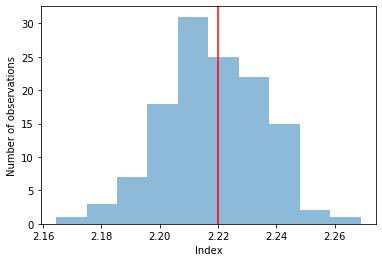

In [15]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel('Index')
plt.ylabel('Number of observations')
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.2877199991966106e-12 += 3.561205938471843e-14


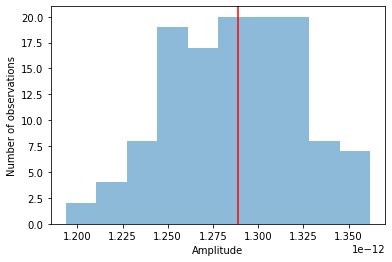

In [16]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel('Amplitude')
plt.ylabel('Number of observations')
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

In [17]:
reference = np.array([_["reference"] for _ in results])
x = np.array([index, amplitude, reference])
covar=np.cov(x)
print(covar)

[[ 2.98392615e-04 -1.88249718e-16  0.00000000e+00]
 [-1.88249718e-16  1.27844634e-27  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [18]:
simu = PowerLawSpectralModel(
    index=index.mean(),
    amplitude=amplitude.mean() * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(simu)

PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.288e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True


In [19]:
i = 0
fpes[i].table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,norm_err,counts [1],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],stat_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.048,0.032,0.072,1.188e-09,4.906e-11,2.248e-12,2.715e-12,1.115,1.495,0.094,2701,0.095,0.094,1.306,12.675,160.649,0.200 .. 5.000,106.808 .. 1151.786,1.324e-09,1.551e-09,1.123e-10,1.129e-10,1.116e-10
0.121,0.072,0.203,1.463e-10,1.962e-11,2.225e-12,2.148e-12,0.987,2.212,0.051,2012,0.051,0.050,1.090,22.558,508.878,0.200 .. 5.000,305.908 .. 3129.501,1.445e-10,1.594e-10,7.402e-12,7.443e-12,7.362e-12
0.307,0.203,0.464,1.803e-11,4.781e-12,1.407e-12,1.699e-12,0.911,2.651,0.054,701,0.055,0.054,1.022,21.186,448.854,0.200 .. 5.000,246.617 .. 2172.835,1.642e-11,1.842e-11,9.776e-13,9.884e-13,9.668e-13
0.702,0.464,1.061,2.802e-12,1.699e-12,1.143e-12,1.380e-12,1.074,6.882,0.064,411,0.065,0.063,1.206,24.132,582.373,0.200 .. 5.000,337.177 .. 1371.975,3.009e-12,3.379e-12,1.791e-13,1.824e-13,1.759e-13
1.778,1.061,2.981,3.452e-13,6.794e-13,1.131e-12,1.092e-12,1.003,2.169,0.062,316,0.063,0.061,1.131,25.620,656.375,0.200 .. 5.000,337.688 .. 1341.421,3.461e-13,3.903e-13,2.135e-14,2.174e-14,2.096e-14
4.507,2.981,6.813,4.252e-14,1.656e-13,7.151e-13,8.636e-13,1.035,1.060,0.086,163,0.088,0.084,1.216,19.788,391.574,0.200 .. 5.000,201.359 .. 684.383,4.399e-14,5.169e-14,3.655e-15,3.759e-15,3.553e-15
10.300,6.813,15.571,6.611e-15,5.882e-14,5.807e-13,7.013e-13,0.970,1.983,0.130,59,0.136,0.124,1.253,12.846,165.021,0.200 .. 5.000,80.253 .. 288.128,6.412e-15,8.284e-15,8.596e-16,8.984e-16,8.218e-16
26.102,15.571,43.755,8.143e-16,2.352e-14,5.748e-13,5.548e-13,0.938,1.090,0.176,30,0.187,0.164,1.334,9.583,91.826,0.200 .. 5.000,42.122 .. 155.386,7.635e-16,1.086e-15,1.430e-16,1.526e-16,1.338e-16


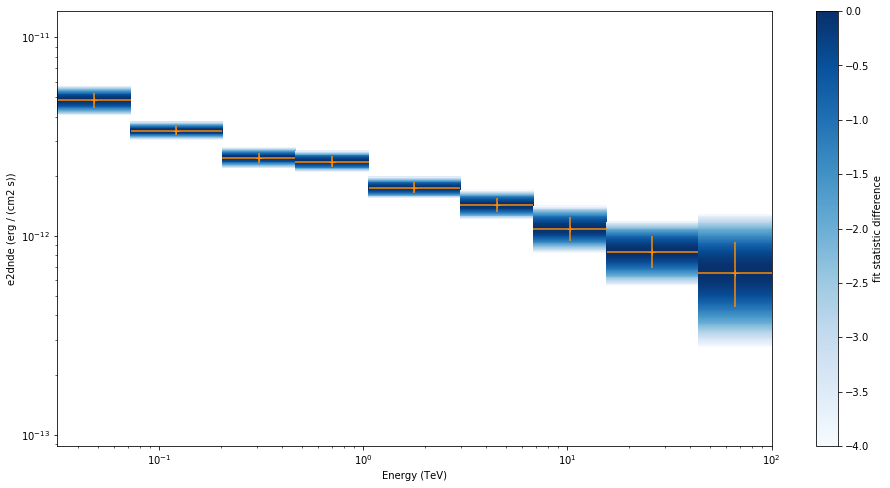

In [20]:
plt.figure(figsize=(16, 8))
fpes[i].table["is_ul"] = fpes[i].table["ts"] < 4
ax = fpes[i].plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
fpes[i].to_sed_type("e2dnde").plot_ts_profiles(ax=ax)

In [21]:
flux_points_dataset = FluxPointsDataset(
    data=fpes[i], models=model_best_joints[i]
)

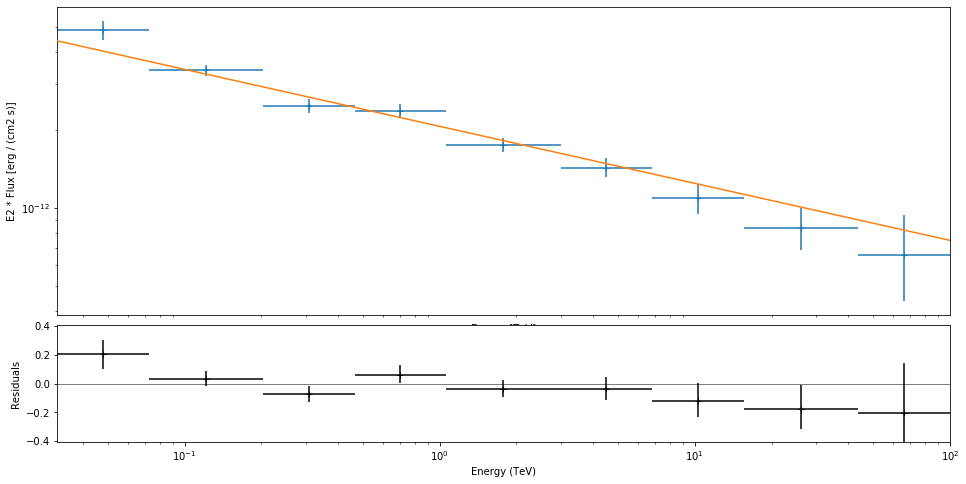

In [22]:
plt.figure(figsize=(16, 8))
flux_points_dataset.peek();

<function matplotlib.pyplot.show(*args, **kw)>

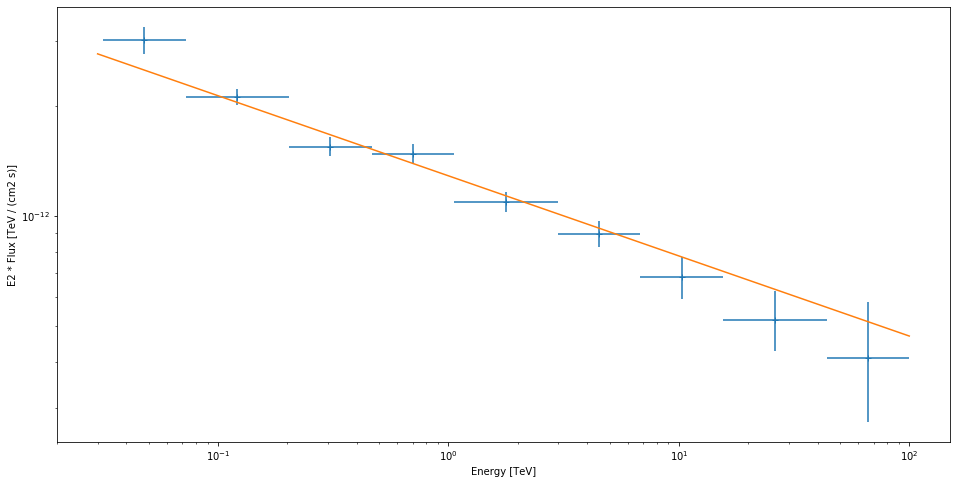

In [23]:
energy_range = [0.03, 100] * u.TeV
plt.figure(figsize=[16,8])
fpes[i].plot(energy_power=2)
simu.plot(energy_range=energy_range, energy_power=2)
plt.show

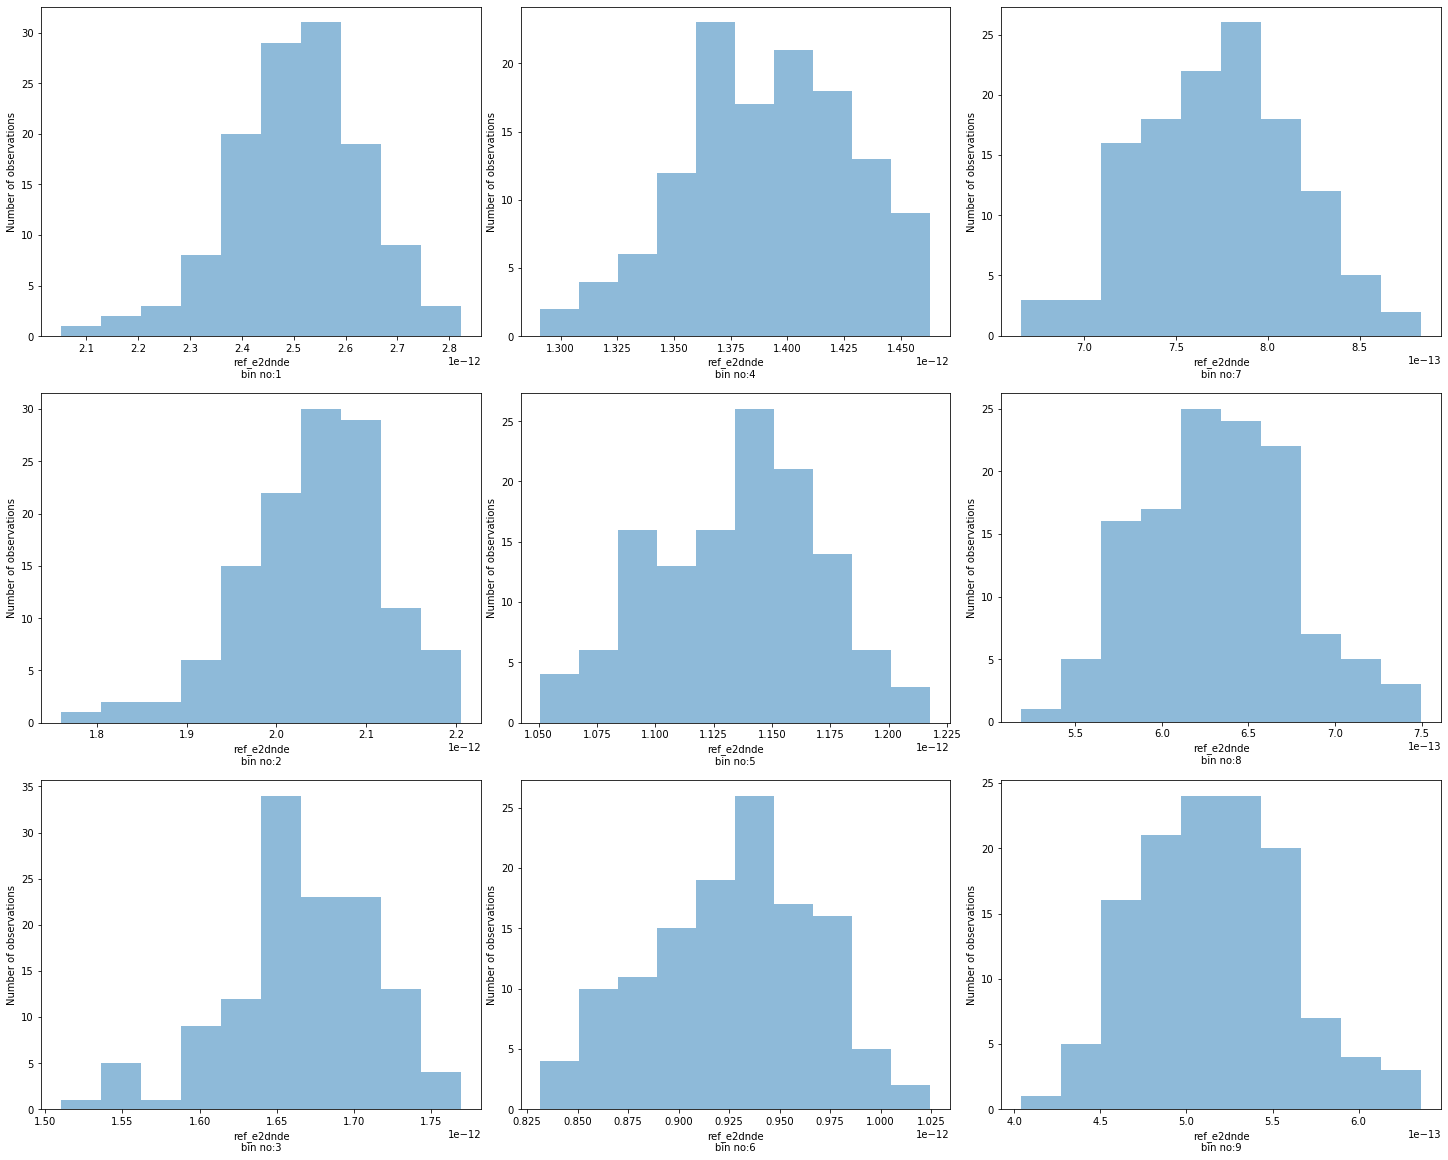

In [24]:
fig = plt.figure(figsize=[20,16],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
for n in range(3):
    ax = fig.add_subplot(gs1[n])
    e_ref_first = np.array([_.table['ref_e2dnde'][n] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'ref_e2dnde\nbin no:{n+1}')
    plt.ylabel('Number of observations')
    
gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1])
for n in range(3):
    ax = fig.add_subplot(gs2[n])
    e_ref_first = np.array([_.table['ref_e2dnde'][n+3] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'ref_e2dnde\nbin no:{n+4}')
    plt.ylabel('Number of observations')

gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[2])
for n in range(3):
    ax = fig.add_subplot(gs3[n])
    e_ref_first = np.array([_.table['ref_e2dnde'][n+6] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'ref_e2dnde\nbin no:{n+7}')
    plt.ylabel('Number of observations')

plt.show()

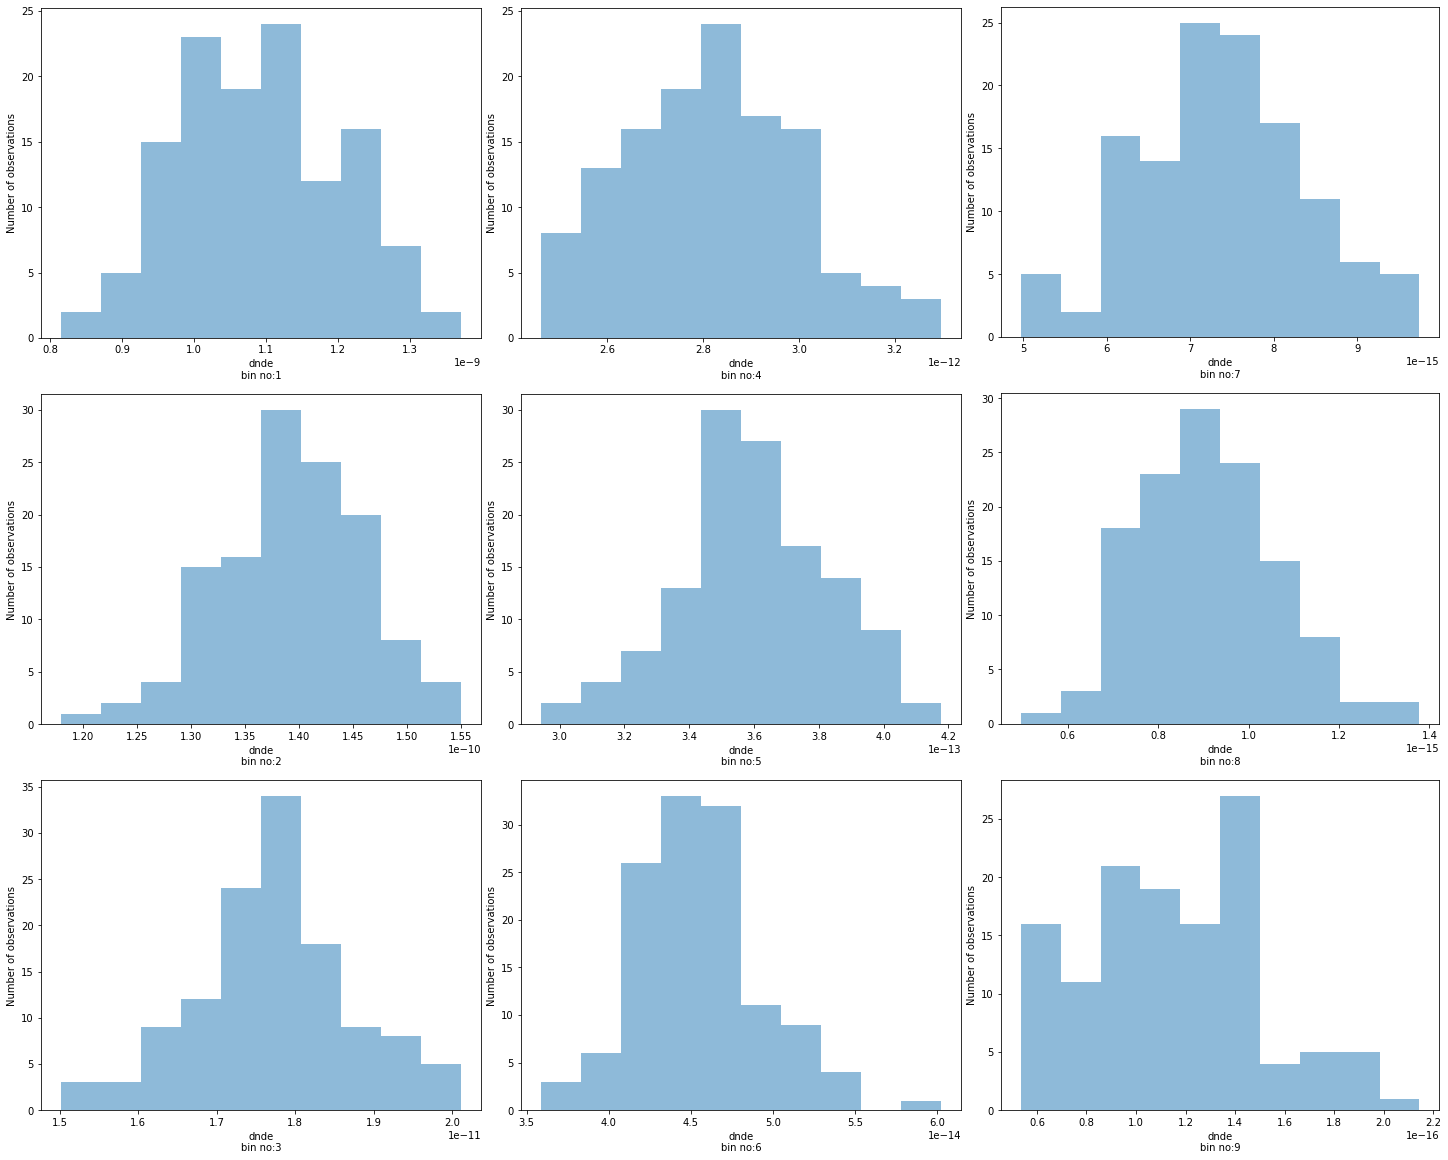

In [25]:
fig = plt.figure(figsize=[20,16],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
for n in range(3):
    ax = fig.add_subplot(gs1[n])
    e_ref_first = np.array([_.table['dnde'][n] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'dnde\nbin no:{n+1}')
    plt.ylabel('Number of observations')
    
gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1])
for n in range(3):
    ax = fig.add_subplot(gs2[n])
    e_ref_first = np.array([_.table['dnde'][n+3] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'dnde\nbin no:{n+4}')
    plt.ylabel('Number of observations')

gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[2])
for n in range(3):
    ax = fig.add_subplot(gs3[n])
    e_ref_first = np.array([_.table['dnde'][n+6] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'dnde\nbin no:{n+7}')
    plt.ylabel('Number of observations')

plt.show()

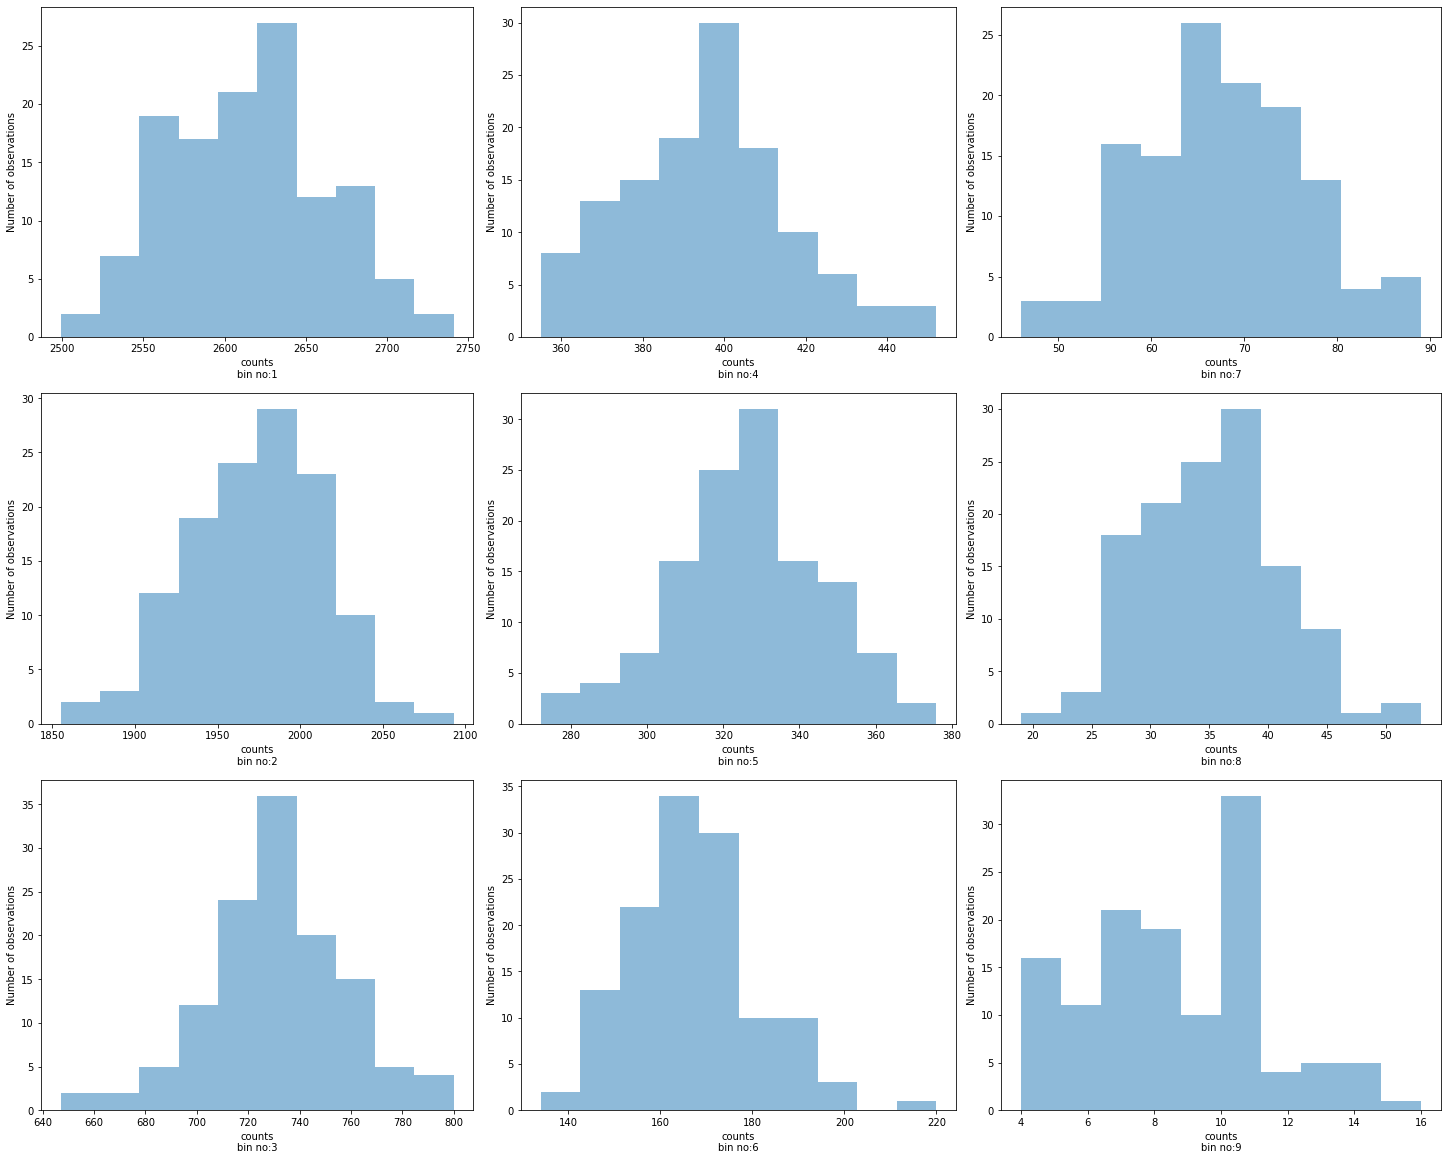

In [26]:
fig = plt.figure(figsize=[20,16],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
for n in range(3):
    ax = fig.add_subplot(gs1[n])
    e_ref_first = np.array([_.table['counts'][n] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'counts\nbin no:{n+1}')
    plt.ylabel('Number of observations')
    
gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1])
for n in range(3):
    ax = fig.add_subplot(gs2[n])
    e_ref_first = np.array([_.table['counts'][n+3] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'counts\nbin no:{n+4}')
    plt.ylabel('Number of observations')

gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[2])
for n in range(3):
    ax = fig.add_subplot(gs3[n])
    e_ref_first = np.array([_.table['counts'][n+6] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'counts\nbin no:{n+7}')
    plt.ylabel('Number of observations')

plt.show()

In [27]:
x = ['e_ref','e_min','e_max','ref_dnde','ref_flux','ref_eflux','ref_e2dnde','norm','stat','norm_err','norm_errp','norm_errn','norm_ul','sqrt_ts','ts','norm_scan','stat_scan','dnde','dnde_ul','dnde_err','dnde_errp','dnde_errn']

In [28]:
flux_points_mean = fpe.run()
flux_points_mean.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,norm_err,counts [1],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],stat_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.048,0.032,0.072,1.074e-09,4.427e-11,2.032e-12,2.455e-12,1.054,4.957,0.103,2622,0.103,0.102,1.261,10.950,119.910,0.200 .. 5.000,81.733 .. 1027.995,1.132e-09,1.355e-09,1.101e-10,1.108e-10,1.094e-10
0.121,0.072,0.203,1.363e-10,1.822e-11,2.072e-12,2.001e-12,0.985,1.565,0.054,1950,0.054,0.053,1.093,21.076,444.177,0.200 .. 5.000,267.432 .. 2853.271,1.343e-10,1.491e-10,7.303e-12,7.339e-12,7.266e-12
0.307,0.203,0.464,1.730e-11,4.579e-12,1.350e-12,1.631e-12,1.051,2.383,0.058,750,0.059,0.058,1.169,23.098,533.519,0.200 .. 5.000,316.651 .. 1897.008,1.818e-11,2.023e-11,1.009e-12,1.013e-12,1.004e-12
0.702,0.464,1.061,2.762e-12,1.671e-12,1.126e-12,1.360e-12,0.947,0.406,0.062,369,0.063,0.061,1.074,21.744,472.815,0.200 .. 5.000,247.590 .. 1455.543,2.615e-12,2.966e-12,1.701e-13,1.731e-13,1.672e-13
1.778,1.061,2.981,3.505e-13,6.875e-13,1.148e-12,1.108e-12,0.998,6.270,0.061,318,0.062,0.060,1.124,25.809,666.085,0.200 .. 5.000,347.954 .. 1373.612,3.497e-13,3.940e-13,2.140e-14,2.179e-14,2.101e-14
4.507,2.981,6.813,4.448e-14,1.728e-13,7.478e-13,9.034e-13,0.930,4.292,0.079,152,0.082,0.077,1.097,19.365,375.020,0.200 .. 5.000,180.561 .. 773.565,4.137e-14,4.881e-14,3.532e-15,3.626e-15,3.439e-15
10.300,6.813,15.571,7.101e-15,6.304e-14,6.235e-13,7.533e-13,1.040,4.505,0.130,68,0.136,0.125,1.322,13.621,185.529,0.200 .. 5.000,98.630 .. 296.867,7.386e-15,9.389e-15,9.243e-16,9.644e-16,8.854e-16
26.102,15.571,43.755,9.011e-16,2.594e-14,6.357e-13,6.139e-13,1.220,7.101,0.188,42,0.198,0.179,1.636,11.975,143.407,0.200 .. 5.000,85.547 .. 148.920,1.099e-15,1.474e-15,1.696e-16,1.785e-16,1.610e-16


In [29]:
for _ in x:
    y = 0
    for bin in fpes:
        y = y + bin.table[_]
    y = y/len(fpes)
    flux_points_mean.table[_] = y
    
y = 0
for bin in fpes:
    y = y + bin.table['counts']
y = y/len(fpes)
flux_points_mean.table['counts'] = y.astype(int)

In [30]:
flux_points_mean.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,norm_err,counts [1],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],stat_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.048,0.032,0.072,1.096e-09,4.519e-11,2.074e-12,2.506e-12,0.995,2.940,0.100,2614,0.101,0.100,1.198,10.587,113.169,0.200 .. 5.000,73.643 .. 1096.033,1.091e-09,1.313e-09,1.096e-10,1.102e-10,1.090e-10
0.121,0.072,0.203,1.392e-10,1.860e-11,2.116e-12,2.044e-12,1.001,3.921,0.053,1972,0.053,0.052,1.107,21.916,481.243,0.200 .. 5.000,293.680 .. 2917.359,1.393e-10,1.541e-10,7.330e-12,7.365e-12,7.295e-12
0.307,0.203,0.464,1.769e-11,4.681e-12,1.380e-12,1.667e-12,1.002,2.847,0.056,731,0.057,0.056,1.117,22.707,516.780,0.200 .. 5.000,299.756 .. 2013.427,1.772e-11,1.976e-11,9.970e-13,1.006e-12,9.876e-13
0.702,0.464,1.061,2.826e-12,1.709e-12,1.152e-12,1.391e-12,0.998,3.030,0.062,395,0.063,0.061,1.127,22.704,516.653,0.200 .. 5.000,283.576 .. 1441.360,2.821e-12,3.185e-12,1.761e-13,1.790e-13,1.732e-13
1.778,1.061,2.981,3.591e-13,7.042e-13,1.176e-12,1.136e-12,1.002,3.391,0.060,326,0.062,0.059,1.127,26.417,699.211,0.200 .. 5.000,360.563 .. 1402.208,3.600e-13,4.049e-13,2.166e-14,2.209e-14,2.123e-14
4.507,2.981,6.813,4.564e-14,1.773e-13,7.673e-13,9.270e-13,0.997,2.910,0.081,166,0.083,0.079,1.167,20.449,419.396,0.200 .. 5.000,210.646 .. 758.250,4.548e-14,5.326e-14,3.697e-15,3.798e-15,3.598e-15
10.300,6.813,15.571,7.298e-15,6.479e-14,6.408e-13,7.742e-13,1.011,3.002,0.126,67,0.132,0.121,1.285,13.789,191.649,0.200 .. 5.000,97.351 .. 310.194,7.387e-15,9.384e-15,9.221e-16,9.605e-16,8.847e-16
26.102,15.571,43.755,9.281e-16,2.671e-14,6.547e-13,6.323e-13,0.985,4.842,0.167,35,0.177,0.158,1.359,10.651,114.501,0.200 .. 5.000,58.648 .. 176.582,9.135e-16,1.259e-15,1.547e-16,1.637e-16,1.460e-16


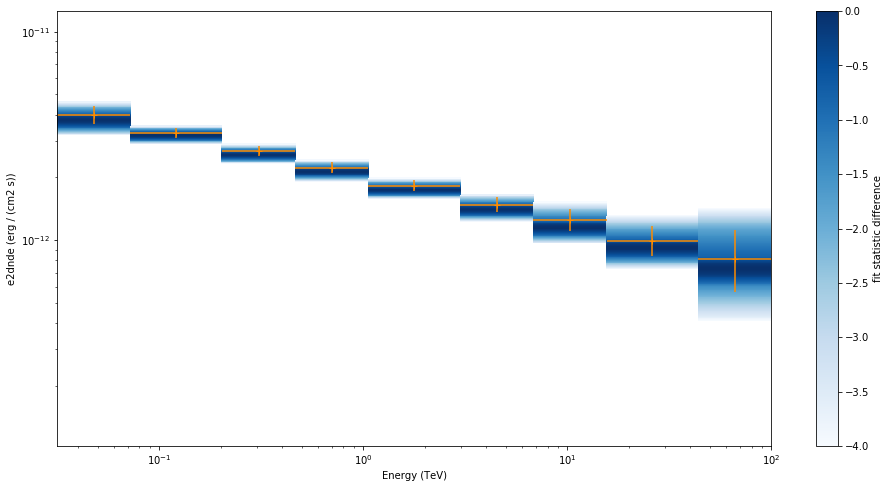

In [31]:
plt.figure(figsize=(16, 8))
flux_points_mean.table["is_ul"] = flux_points_mean.table["ts"] < 4
ax = flux_points_mean.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
flux_points_mean.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)

In [32]:
flux_points_dataset = FluxPointsDataset(
    data=flux_points_mean, models=model_best_joints[124]
)

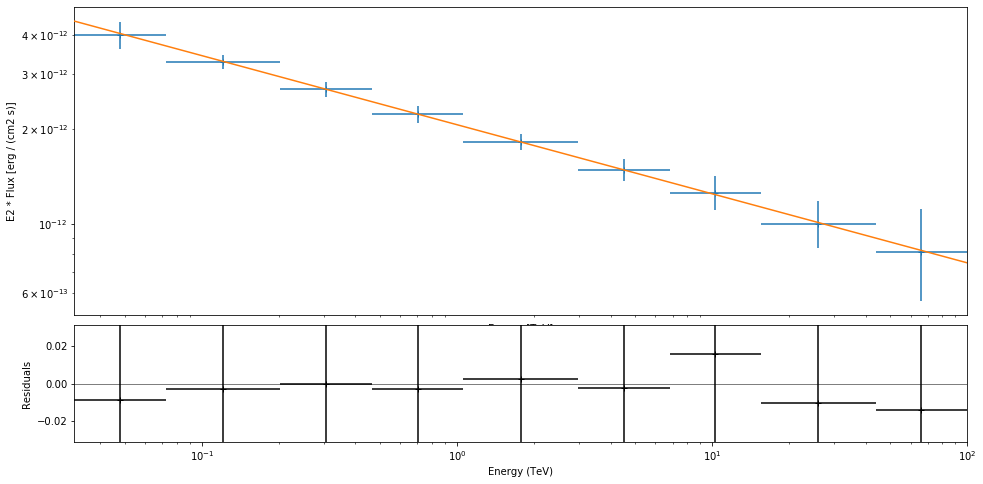

In [33]:
plt.figure(figsize=(16, 8))
flux_points_dataset.peek();

<function matplotlib.pyplot.show(*args, **kw)>

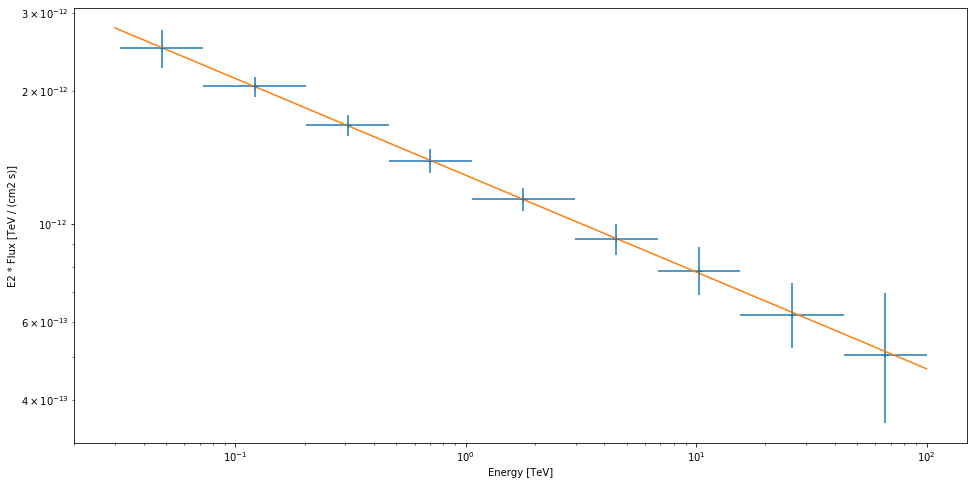

In [34]:
plt.figure(figsize=[16,8])
flux_points_mean.plot(energy_power=2)
simu.plot(energy_range=energy_range, energy_power=2)
plt.show

In [35]:
fp = FluxPointsEstimator(datasets=datasets, e_edges=e_edges)
flu_pois = fp.run()

In [36]:
flu_pois.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,norm_err,counts [125],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],stat_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.048,0.032,0.072,1.188e-09,4.906e-11,2.248e-12,2.715e-12,0.922,493.830,0.008,2701 .. 2622,0.008,0.008,0.939,118.405,14019.799,0.200 .. 5.000,8857.908 .. 160646.133,1.095e-09,1.115e-09,9.836e-12,9.841e-12,9.831e-12
0.121,0.072,0.203,1.463e-10,1.962e-11,2.225e-12,2.148e-12,0.952,599.758,0.004,2012 .. 1950,0.004,0.004,0.961,245.042,60045.753,0.200 .. 5.000,35736.104 .. 400758.733,1.393e-10,1.406e-10,6.555e-13,6.538e-13,6.572e-13
0.307,0.203,0.464,1.803e-11,4.781e-12,1.407e-12,1.699e-12,0.983,479.395,0.005,701 .. 750,0.005,0.005,0.993,253.917,64474.024,0.200 .. 5.000,37063.409 .. 260536.642,1.772e-11,1.790e-11,8.915e-14,8.849e-14,8.982e-14
0.702,0.464,1.061,2.802e-12,1.699e-12,1.143e-12,1.380e-12,1.007,501.883,0.006,411 .. 369,0.006,0.006,1.018,253.887,64458.515,0.200 .. 5.000,35674.936 .. 177698.758,2.821e-12,2.853e-12,1.575e-14,1.577e-14,1.572e-14
1.778,1.061,2.981,3.452e-13,6.794e-13,1.131e-12,1.092e-12,1.043,587.029,0.006,316 .. 318,0.006,0.006,1.055,295.361,87238.299,0.200 .. 5.000,46441.250 .. 163837.580,3.602e-13,3.641e-13,1.939e-15,1.943e-15,1.935e-15
4.507,2.981,6.813,4.252e-14,1.656e-13,7.151e-13,8.636e-13,1.068,503.377,0.008,163 .. 152,0.008,0.008,1.084,228.659,52284.800,0.200 .. 5.000,27752.984 .. 84224.649,4.543e-14,4.610e-14,3.306e-16,3.318e-16,3.294e-16
10.300,6.813,15.571,6.611e-15,5.882e-14,5.807e-13,7.013e-13,1.116,524.492,0.012,59 .. 68,0.013,0.012,1.141,154.295,23806.881,0.200 .. 5.000,13115.675 .. 32887.141,7.377e-15,7.544e-15,8.253e-17,8.326e-17,8.181e-17
26.102,15.571,43.755,8.143e-16,2.352e-14,5.748e-13,5.548e-13,1.118,725.974,0.017,30 .. 42,0.017,0.017,1.153,119.130,14191.904,0.200 .. 5.000,8078.689 .. 17901.555,9.107e-16,9.387e-16,1.384e-17,1.399e-17,1.370e-17


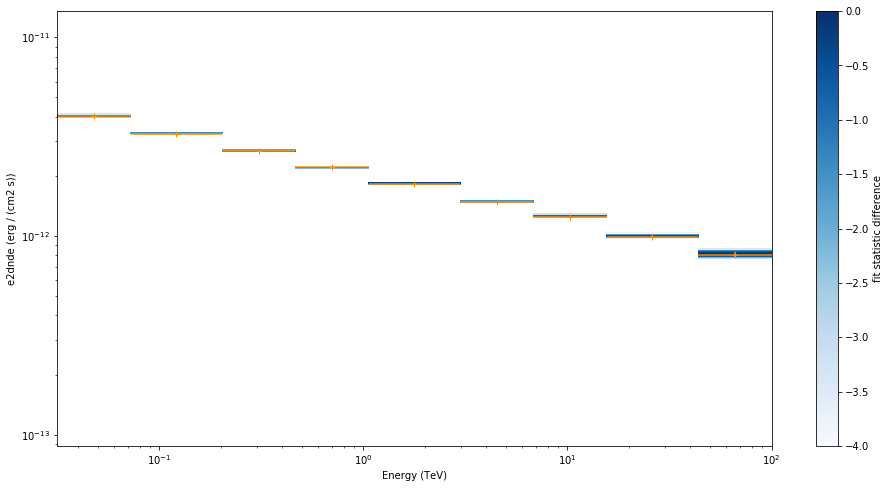

In [37]:
plt.figure(figsize=(16, 8))
flu_pois.table["is_ul"] = flu_pois.table["ts"] < 4
ax = flu_pois.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
flu_pois.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)

In [38]:
flu_pois_dataset = FluxPointsDataset(
    data=flu_pois, models=model_best_joints[124]
)

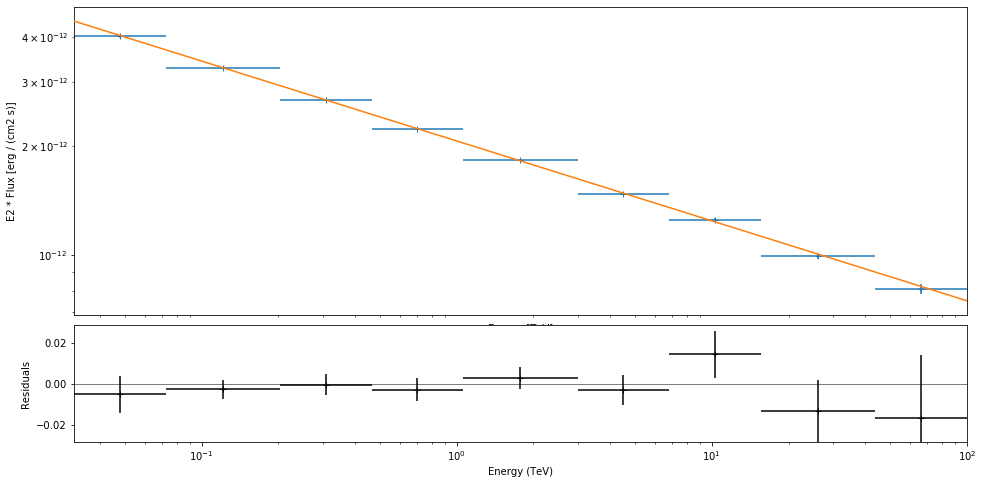

In [39]:
plt.figure(figsize=(16, 8))
flu_pois_dataset.peek();

<function matplotlib.pyplot.show(*args, **kw)>

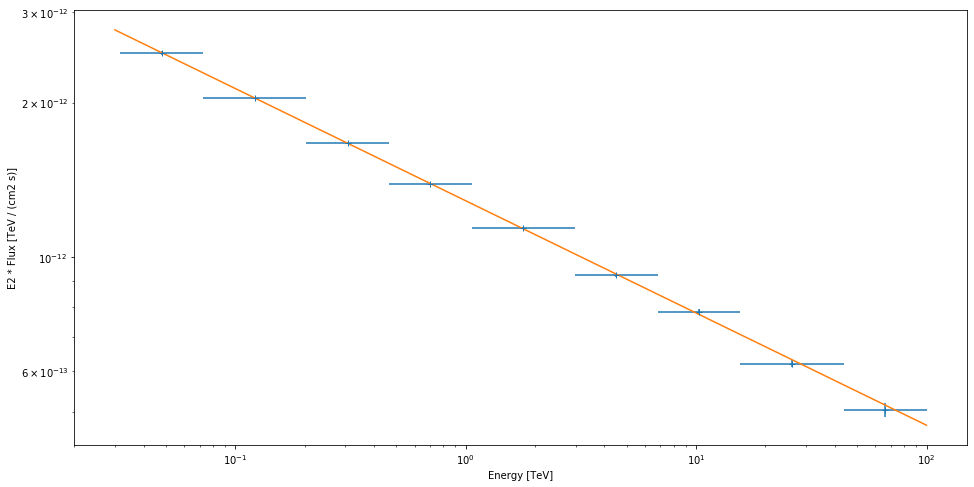

In [40]:
plt.figure(figsize=[16,8])
flu_pois.plot(energy_power=2)
simu.plot(energy_range=energy_range, energy_power=2)
plt.show

In [41]:
stacked_dataset = Datasets(datasets).stack_reduce()

print(stacked_dataset)

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 789836 
    Total predicted counts          : 797627.29
    Total off counts                : 2209688.00

    Total background counts         : 441937.60

    Effective area min              : 2.80e+08 cm2
    Effective area max              : 5.73e+10 cm2

    Livetime                        : 1.00e+03 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 572.97

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [42]:
stacked_dataset.model = model

fp = FluxPointsEstimator(datasets=[stacked_dataset], e_edges=e_edges)
flu_pois = fp.run()
flu_pois.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,norm_err,counts [1],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],stat_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.048,0.032,0.072,1.188e-09,4.906e-11,2.248e-12,2.715e-12,0.922,0.671,0.008,326808,0.008,0.008,0.939,118.394,14017.198,0.200 .. 5.000,8362.809 .. 160156.083,1.095e-09,1.115e-09,9.836e-12,9.841e-12,9.831e-12
0.121,0.072,0.203,1.463e-10,1.962e-11,2.225e-12,2.148e-12,0.952,3.321,0.004,246517,0.004,0.004,0.961,245.043,60046.255,0.200 .. 5.000,35140.526 .. 400162.680,1.393e-10,1.406e-10,6.555e-13,6.538e-13,6.572e-13
0.307,0.203,0.464,1.803e-11,4.781e-12,1.407e-12,1.699e-12,0.983,7.349,0.005,91477,0.005,0.005,0.993,253.924,64477.213,0.200 .. 5.000,36594.077 .. 260062.853,1.772e-11,1.790e-11,8.915e-14,8.850e-14,8.982e-14
0.702,0.464,1.061,2.802e-12,1.699e-12,1.143e-12,1.380e-12,1.007,4.834,0.006,49443,0.006,0.006,1.018,253.886,64457.912,0.200 .. 5.000,35177.243 .. 177200.528,2.821e-12,2.853e-12,1.575e-14,1.577e-14,1.572e-14
1.778,1.061,2.981,3.452e-13,6.794e-13,1.131e-12,1.092e-12,1.043,15.881,0.006,40757,0.006,0.006,1.055,295.349,87230.960,0.200 .. 5.000,45855.884 .. 163271.076,3.601e-13,3.640e-13,1.939e-15,1.943e-15,1.935e-15
4.507,2.981,6.813,4.252e-14,1.656e-13,7.151e-13,8.636e-13,1.069,6.461,0.008,20868,0.008,0.008,1.084,228.743,52323.226,0.200 .. 5.000,27277.686 .. 83725.044,4.544e-14,4.610e-14,3.306e-16,3.318e-16,3.294e-16
10.300,6.813,15.571,6.611e-15,5.882e-14,5.807e-13,7.013e-13,1.116,7.224,0.012,8496,0.013,0.012,1.141,154.046,23730.063,0.200 .. 5.000,12541.330 .. 32372.684,7.376e-15,7.542e-15,8.253e-17,8.326e-17,8.182e-17
26.102,15.571,43.755,8.143e-16,2.352e-14,5.748e-13,5.548e-13,1.118,1.914,0.017,4393,0.017,0.017,1.153,121.084,14661.400,0.200 .. 5.000,7484.798 .. 17177.061,9.107e-16,9.388e-16,1.384e-17,1.399e-17,1.370e-17


In [43]:
datasets[0].edisp.to_table()

ENERG_LO,ENERG_HI,N_GRP,F_CHAN,N_CHAN,MATRIX
TeV,TeV,,,,
float64,float64,int16,object,object,object
0.0316227766016838,0.0329297125509715,1,[0],[4],[0.37030434 0.12980831 0.03220612 0.00911744]
0.0329297125509715,0.034290662782339984,1,[0],[5],[0.44966429 0.12873106 0.04719896 0.0203101 0.02035599]
0.034290662782339984,0.035707859649004636,1,[0],[4],[0.28760593 0.26002035 0.14893997 0.01976812]
0.035707859649004636,0.037183627764980874,1,[0],[4],[0.43400932 0.33356029 0.04667589 0.01710435]
0.037183627764980874,0.03872038781812555,1,[0],[5],[0.38084856 0.29239337 0.11519399 0.04174333 0.010126 ]
0.03872038781812555,0.04032066054076736,1,[0],[5],[0.20218768 0.41744356 0.20919646 0.02878125 0.00729188]
0.04032066054076736,0.0419870708444391,1,[0],[5],[0.24224841 0.48474054 0.10097427 0.02321799 0.02347255]
0.0419870708444391,0.043722352125494135,1,[0],[5],[0.20860388 0.36164042 0.23668035 0.13087963 0.0284858 ]


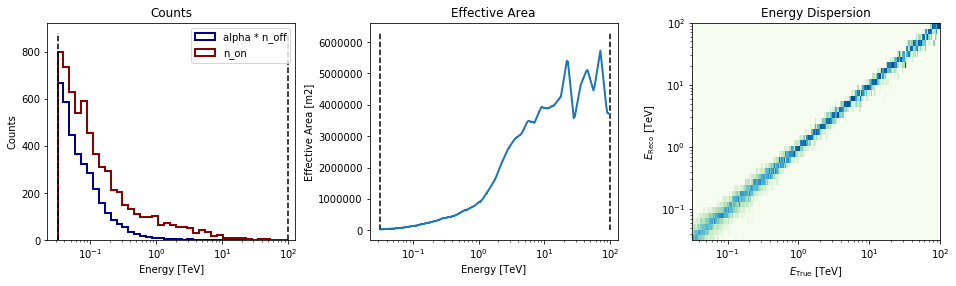

In [44]:
datasets[0].peek()

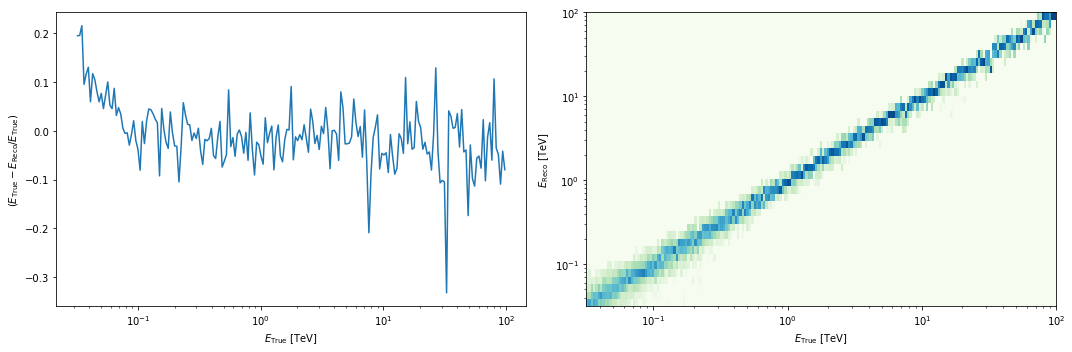

In [45]:
datasets[100].edisp.peek()